# OxCOVID19 (https://covid19.eng.ox.ac.uk/) - Confirmed cases for Poland


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [2]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()

# Retrieving epidemiology data for single source 

In [3]:
# Load all data for region 1
sql_command = """SELECT * FROM epidemiology WHERE source = %(source)s AND adm_area_1 <> '' ORDER by date DESC"""
df = pd.read_sql(sql_command, conn, params={'source': 'POL_WIKI'})
df.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid
0,POL_WIKI,2020-10-05,Poland,POL,Dolnośląskie,None,None,None,5572.0,None,NaN,None,None,None,[POL.1_1]
1,POL_WIKI,2020-10-05,Poland,POL,Zachodniopomorskie,None,None,None,2144.0,None,NaN,None,None,None,[POL.16_1]
2,POL_WIKI,2020-10-05,Poland,POL,Wielkopolskie,None,None,None,8743.0,None,NaN,None,None,None,[POL.15_1]
3,POL_WIKI,2020-10-05,Poland,POL,Warmińsko-Mazurskie,None,None,None,1990.0,None,NaN,None,None,None,[POL.14_1]
4,POL_WIKI,2020-10-05,Poland,POL,Śląskie,None,None,None,23412.0,None,NaN,None,None,None,[POL.12_1]


# Extracting only recent data - total per region

In [4]:
df_recent = df.copy()
df_recent['gid'] = [','.join(map(str, l)) for l in df['gid']]
df_recent = df_recent.sort_values('date').groupby('adm_area_1').apply(lambda x: x.max())

df_recent = df_recent.set_index('date')
df_recent[["country", "adm_area_1", "confirmed", "recovered", "dead", "gid"]].head(30)

,country,adm_area_1,confirmed,recovered,dead,gid
date,,,,,,
2020-10-05,Poland,Dolnośląskie,5572.0,NaN,166.0,POL.1_1
2020-10-05,Poland,Kujawsko-Pomorskie,3531.0,NaN,54.0,POL.2_1
2020-10-05,Poland,Lubelskie,3274.0,NaN,26.0,POL.4_1
2020-10-05,Poland,Lubuskie,1277.0,NaN,14.0,POL.5_1
2020-10-05,Poland,Mazowieckie,14031.0,NaN,403.0,POL.7_1
2020-10-05,Poland,Małopolskie,12475.0,NaN,123.0,POL.6_1
2020-10-05,Poland,Opolskie,2583.0,NaN,59.0,POL.8_1
2020-10-05,Poland,Podkarpackie,4634.0,NaN,79.0,POL.9_1
2020-10-05,Poland,Podlaskie,2496.0,NaN,28.0,POL.10_1


### Retrieving administrative division level 1 for single country from covid19db

In [7]:
# Get Covid19db administrative division
import geopandas as gpd
def get_administrative_division(level=0, countrycode=None):
    sql = f"SELECT * FROM administrative_division WHERE adm_level={level} "
    if level>0 and countrycode: 
        sql = sql +  f"AND countrycode='{countrycode}'"

    admin_data = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')
    admin_data["area"] = admin_data['geometry'].area
    return admin_data

In [8]:
admin_1_data = get_administrative_division(level=1, countrycode='POL')
admin_1_data.head()

<ipython-input-7-461c9366afaf>:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  admin_data["area"] = admin_data['geometry'].area


,country,countrycode,countrycode_alpha2,adm_level,adm_area_1,adm_area_1_code,adm_area_2,adm_area_2_code,adm_area_3,adm_area_3_code,gid,latitude,longitude,properties,geometry,area
0,Poland,POL,PL,1,Lubuskie,POL.5_1,None,None,None,None,POL.5_1,52.196173,15.342746,"{'CC_1': '08', 'GID_0': 'POL', 'GID_1': 'POL.5...","POLYGON ((15.12407 51.43452, 15.08793 51.42726...",1.838208
1,Poland,POL,PL,1,Dolnośląskie,POL.1_1,None,None,None,None,POL.1_1,51.090451,16.411440,"{'CC_1': '02', 'GID_0': 'POL', 'GID_1': 'POL.1...","POLYGON ((15.06966 51.01997, 15.03803 51.01222...",2.554630
2,Poland,POL,PL,1,Kujawsko-Pomorskie,POL.2_1,None,None,None,None,POL.2_1,53.072704,18.488217,"{'CC_1': '04', 'GID_0': 'POL', 'GID_1': 'POL.2...","POLYGON ((18.23998 52.48726, 18.20458 52.48317...",2.411728
3,Poland,POL,PL,1,Łódzkie,POL.3_1,None,None,None,None,POL.3_1,51.604865,19.417596,"{'CC_1': '10', 'GID_0': 'POL', 'GID_1': 'POL.3...","POLYGON ((19.81074 50.90792, 19.72790 50.84328...",2.364374
4,Poland,POL,PL,1,Lubelskie,POL.4_1,None,None,None,None,POL.4_1,51.221061,22.899078,"{'CC_1': '06', 'GID_0': 'POL', 'GID_1': 'POL.4...","POLYGON ((23.40326 50.30130, 23.43580 50.34699...",3.227790


# Merge administrative division and epidemiology data


In [9]:
data_pd = df_recent.merge(admin_1_data, how = 'outer', left_on = 'gid', right_on = 'gid', suffixes=('', '_y'))
data_pd = gpd.GeoDataFrame(data_pd, geometry='geometry')
data_pd.head()

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area
0,POL_WIKI,Poland,POL,Dolnośląskie,NaN,NaN,NaN,5572.0,NaN,166.0,...,POL.1_1,None,None,None,None,51.090451,16.411440,"{'CC_1': '02', 'GID_0': 'POL', 'GID_1': 'POL.1...","POLYGON ((15.06966 51.01997, 15.03803 51.01222...",2.554630
1,POL_WIKI,Poland,POL,Kujawsko-Pomorskie,NaN,NaN,NaN,3531.0,NaN,54.0,...,POL.2_1,None,None,None,None,53.072704,18.488217,"{'CC_1': '04', 'GID_0': 'POL', 'GID_1': 'POL.2...","POLYGON ((18.23998 52.48726, 18.20458 52.48317...",2.411728
2,POL_WIKI,Poland,POL,Lubelskie,NaN,NaN,NaN,3274.0,NaN,26.0,...,POL.4_1,None,None,None,None,51.221061,22.899078,"{'CC_1': '06', 'GID_0': 'POL', 'GID_1': 'POL.4...","POLYGON ((23.40326 50.30130, 23.43580 50.34699...",3.227790
3,POL_WIKI,Poland,POL,Lubuskie,NaN,NaN,NaN,1277.0,NaN,14.0,...,POL.5_1,None,None,None,None,52.196173,15.342746,"{'CC_1': '08', 'GID_0': 'POL', 'GID_1': 'POL.5...","POLYGON ((15.12407 51.43452, 15.08793 51.42726...",1.838208
4,POL_WIKI,Poland,POL,Mazowieckie,NaN,NaN,NaN,14031.0,NaN,403.0,...,POL.7_1,None,None,None,None,52.345758,21.096445,"{'CC_1': '14', 'GID_0': 'POL', 'GID_1': 'POL.7...","POLYGON ((21.06840 51.20693, 21.05656 51.15711...",4.687067


# TEST 1: Checking unmatched regions

### Result should be empty - if not try to correct your fetcher, probably there is a mismatch in adm_areas

In [10]:
# If this is not empty region matching has to be corrected !!!!!
unmatched_regions = data_pd[(data_pd.geometry.isna() | data_pd.countrycode.isna() | data_pd.countrycode_y.isna())]
unmatched_regions

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area


# Plotting functions

In [11]:
from termcolor import colored
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt

def choropleth_administrative_division(data, hue, label=None, cmap='Reds', k=10, add_text=False):
    schema = mc.Quantiles(data[hue], k=k) 
    gplt.choropleth(
        data,     
        hue=hue,     
        edgecolor='white', 
        linewidth=1,
        cmap=cmap,
        scheme=schema,
        legend=True, 
        legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
    )
    if add_text:
        label = label or hue
        for _, row in data.iterrows():
          plt.text(s=row[label], x = row['longitude'], y = row['latitude'],
                   horizontalalignment='center', 
                   fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'darkgray',})
        
        
def plot_time_series(data, col):
    for key, grp in df.groupby(['adm_area_1']): 
        grp = grp[grp[col].notna()] # Drop NA
        plt.plot(grp.date, grp[col], '-o', linewidth=4.0, label=key)
        if not grp[col].is_monotonic_decreasing:
            print(colored(f'Series in not monotonic increasing: {key}', 'red'))
            print(grp[['date', col]])

    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5)) 
    plt.grid()
    plt.title(f'{col} cases per adm_area_1');
    plt.show()

# TEST 2: Regions matching test - check if data is matched correctly with regions

/Users/piotrblaszczyk/Environments/python3.8/lib/python3.8/site-packages/mapclassify/classifiers.py:888: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


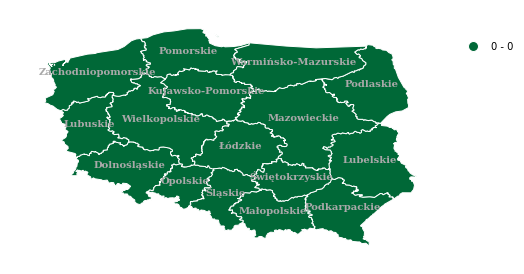

In [12]:
def check(x):
    if pd.isnull(x['countrycode']) or pd.isnull(x['countrycode_y']):
        return 1
    return 0
    
data_pd['errors'] = data_pd.apply(lambda x: check(x), axis=1)
choropleth_administrative_division(data_pd, 'errors', 
                                   label='adm_area_1', 
                                   cmap='RdYlGn_r', 
                                   add_text=True,
                                   k=len(data_pd.errors.unique()))

# Red - problem (incorrect matching, data missing)
# Green - OK

# Plot epidemiology total confirmed


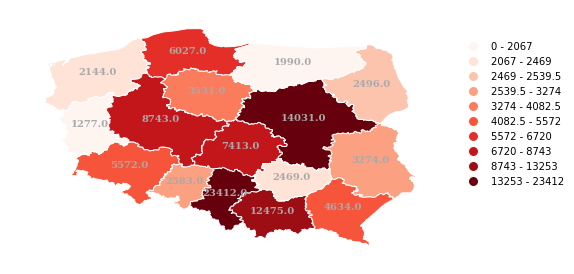

In [13]:
data_pd['confirmed'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'confirmed', add_text=True)

# Plot epidemiology total deaths

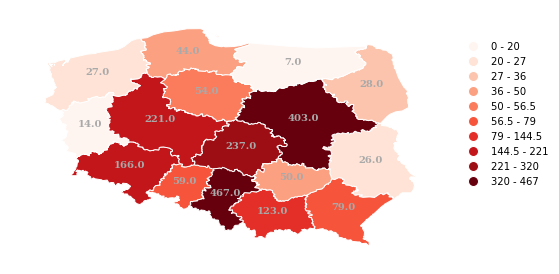

In [14]:
data_pd['dead'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'dead', add_text=True)

# TEST 3: checking the monotonicity of data - confirmed

Series in not monotonic increasing: Podlaskie
            date  confirmed
8     2020-10-05     2496.0
31    2020-10-04     2406.0
47    2020-10-03     2330.0
56    2020-10-02     2204.0
65    2020-10-01     2118.0
...          ...        ...
2988  2020-03-21        5.0
3004  2020-03-20        3.0
3010  2020-03-19        1.0
3025  2020-03-18        2.0
3036  2020-03-17        1.0

[190 rows x 2 columns]


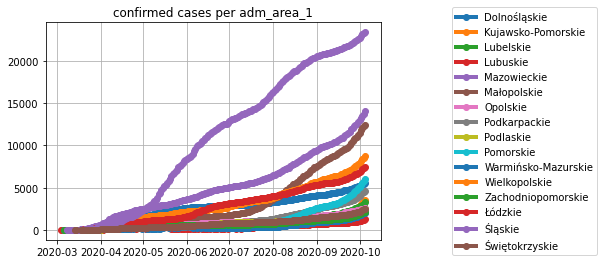

In [15]:
plot_time_series(df, 'confirmed')

# TEST 4: checking the monotonicity of data - dead

Series in not monotonic increasing: Pomorskie
            date  dead
696   2020-08-23  44.0
729   2020-08-21  43.0
749   2020-08-20  42.0
784   2020-08-17  41.0
836   2020-08-14  40.0
848   2020-08-13  41.0
890   2020-08-11  40.0
1268  2020-07-18  39.0
1747  2020-06-15  38.0
1845  2020-06-08  37.0
1884  2020-06-05  36.0
1970  2020-05-30  35.0
1986  2020-05-29  34.0
2013  2020-05-27  33.0
2019  2020-05-26  32.0
2059  2020-05-23  30.0
2122  2020-05-19  29.0
2213  2020-05-12  28.0
2228  2020-05-11  27.0
2235  2020-05-10  26.0
2256  2020-05-09  24.0
2265  2020-05-08  23.0
2290  2020-05-07  22.0
2298  2020-05-06  21.0
2308  2020-05-05  19.0
2332  2020-05-04  18.0
2335  2020-05-03  15.0
2360  2020-05-02  14.0
2366  2020-05-01  12.0
2386  2020-04-30  11.0
2392  2020-04-29  10.0
2414  2020-04-28   8.0
2420  2020-04-27   5.0
2495  2020-04-22   3.0
2591  2020-04-16   2.0
2705  2020-04-08   1.0
Series in not monotonic increasing: Łódzkie
            date   dead
627   2020-08-27  237.0
654   2020-

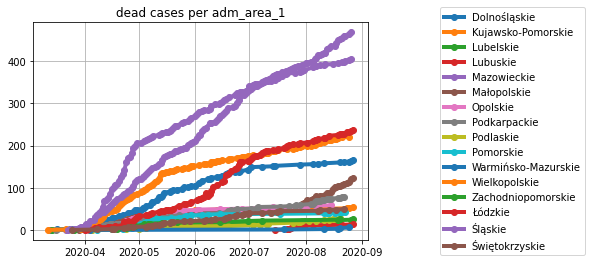

In [16]:
plot_time_series(df, 'dead')